In [1]:
import sys
import os
import numpy as np
from numpy.linalg import multi_dot, lstsq
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import normalize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel, ExpSineSquared
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss, r2_score

from scipy.linalg import expm, solve_continuous_lyapunov

#from skgstat import Variogram

from joblib import dump, load

#Libraries for checkpoints during training
#from skopt import callbacks
#from skopt.callbacks import CheckpointSaver

#from plotters import plot_gp, plot_gp_example, plot_residuals

In [5]:
df = pd.read_csv('../../GME.csv')

In [11]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

<AxesSubplot:>

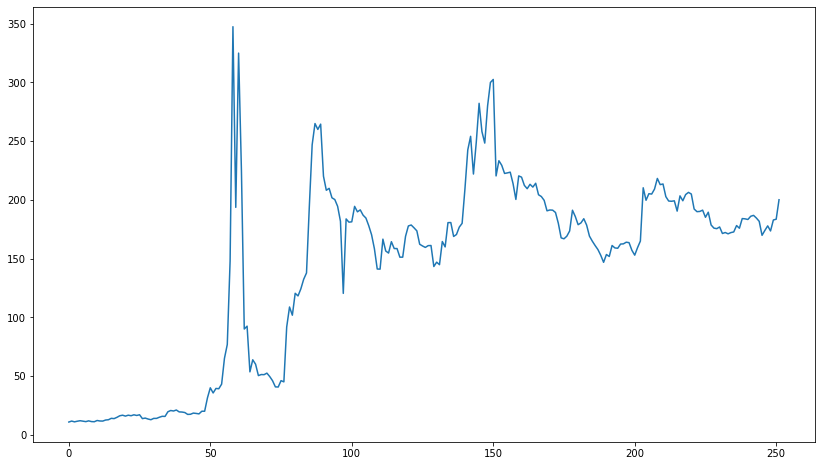

In [114]:
df["Close"].plot(figsize=(14,8))

C:\Users\Lars Martin\.conda\envs\oxygenModel\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


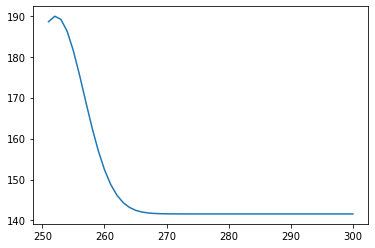

In [99]:
# Instantiate a Gaussian Process model
kernel = ConstantKernel(10) *RBF(1, (1e-2, 1e2)) + ConstantKernel(5) * ExpSineSquared(2, 3.0)    # 1.16**2 * RBF(length_scale=79.5) + 0.536**2 * ExpSineSquared(length_scale=0.108, periodicity=202)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=7, alpha = 0.1, normalize_y=True)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
X = np.array(df["Date"].index.tolist()).reshape(-1,1)
x = np.arange(df["Date"].index[-1], df["Date"].index[-1] + 50).reshape(-1,1)
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, df["Close"])

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

gp.kernel_
#df["Close"].plot(figsize = (12,8))
plt.plot(x, y_pred)

In [94]:
gp.kernel_

0.493**2 * RBF(length_scale=3.41) + 0.984**2 * ExpSineSquared(length_scale=0.0447, periodicity=9.96e+03)

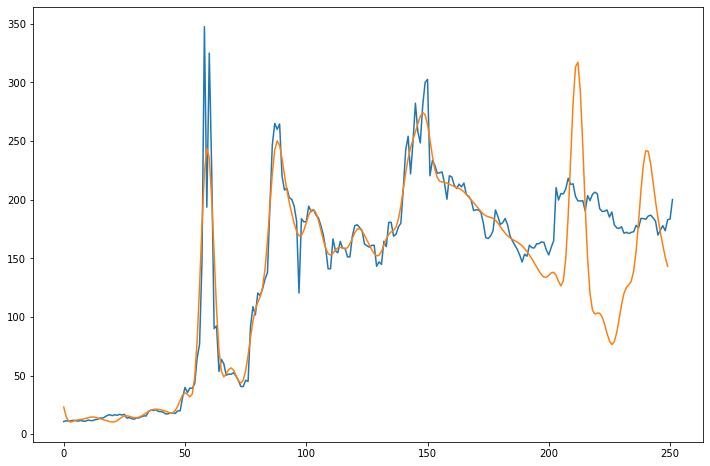

In [175]:
#df["Close"].plot(figsize = (12,8))
kernel2 = (ConstantKernel(50) * ExpSineSquared(100, 90)) + ConstantKernel(50) * RBF(10)
gp2 = GaussianProcessRegressor(kernel=kernel2, n_restarts_optimizer=9, alpha = 0.1, normalize_y=True)
gp2.fit(X[0:175], df["Close"][0:175])
#gp2.kernel_ = 1.16**2 * RBF(length_scale=79.5) + 0.536**2 * ExpSineSquared(length_scale=0.108, periodicity=202)
y_pred2, sigma2 = gp2.predict(X[0:250], return_std = True)
df["Close"].plot(figsize = (12,8))
plt.plot(X[0:250], y_pred2)

In [177]:
gp2.kernel_

0.526**2 * ExpSineSquared(length_scale=0.137, periodicity=153) + 1.12**2 * RBF(length_scale=83.2)

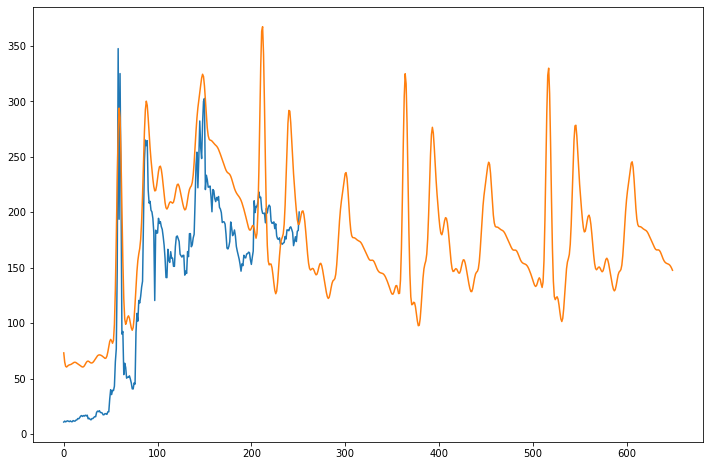

In [161]:
y_pred2, sigma2 = gp2.predict(np.arange(0,650).reshape(-1,1), return_std = True)
y_pred2 += 50
df["Close"].plot(figsize = (12,8))
plt.plot(np.arange(0,650), y_pred2)

In [158]:
gp2.kernel_

0.00327**2 * RBF(length_scale=0.0591) * 0.00717**2 * ExpSineSquared(length_scale=0.677, periodicity=0.621) + 0.526**2 * ExpSineSquared(length_scale=0.137, periodicity=153) + 1.12**2 * RBF(length_scale=83.2)